### 목적 :
- 간단한 합성곱 신경망 구현과 그 안에 원리를 세부적으로 정확히 코딩을 통해 이해해본다.

### 수업 진행 :
1. 간단한 합성곱신경망을 사용한 MNIST 분류 문제 설계 및 학습(큰 흐름 개괄)
2. Convoltional layer는 [Convolution, Activation function, Pooling] 3가지로 구성되어 있고, 각 구성요소 따라가보기

### Convolution이 하나만 있는 아래와 같은 단순한 합성곱 신경망을 코드로 구현해보자

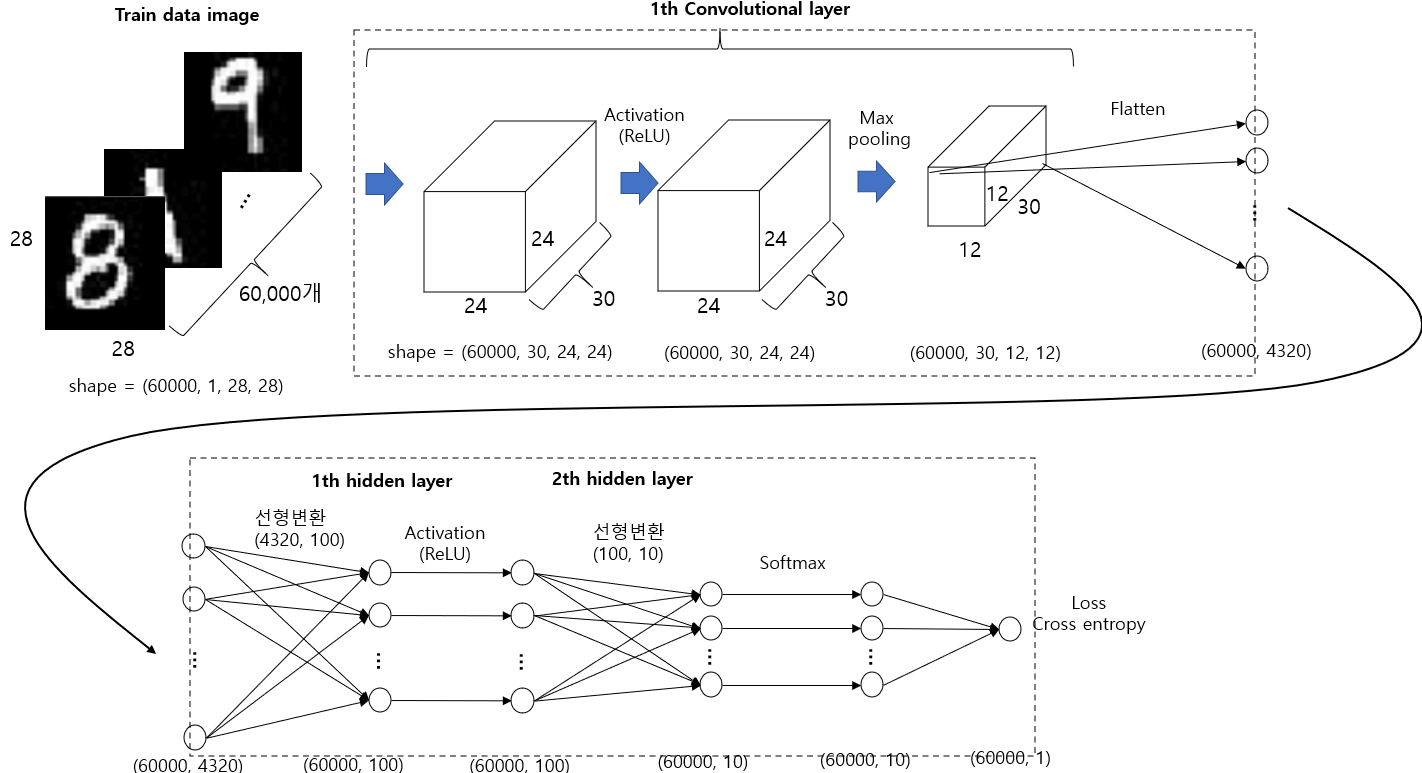

# 
## 1. 간단한 합성곱신경망을 사용한 MNIST 분류 문제 설계 및 학습(큰 흐름 개괄)

#### 1. 필요 라이브러리 로드 및 데이터셋 준비

In [1]:
import sys, os
import matplotlib.pyplot as plt

# 1) 현재 노트북(Project/)의 상위 폴더(2025 비교과특강/) 절대경로
base_dir = os.path.abspath('..')

# 2) 중복 추가 방지 후 sys.path에 삽입
if base_dir not in sys.path:
    sys.path.append(base_dir)

# (옵션) 변경된 모듈 자동 반영
%load_ext autoreload
%autoreload 2

In [2]:
# 함수·레이어·최적화 기법 등 필요한 모듈을 한 번에 가져오기
from common.functions               import *
from common.gradient                import *
from common.layers                  import *
from common.multi_layer_net         import *
from common.multi_layer_net_extend  import *
from common.optimizer               import *
from common.trainer                 import *
from common.util                    import *

In [3]:
import tensorflow as tf

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

X_train = np.reshape(X_train, (-1, 1, 28,28))
X_test = np.reshape(X_test, (-1,1,28,28))

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

X_train /= 255.
X_test /= 255.

print(np.max(X_train))
print(np.min(X_train))
print(np.max(X_test))
print(np.min(X_test))

Train images shape: (60000, 1, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 1, 28, 28)
Test labels shape: (10000,)
1.0
0.0
1.0
0.0


In [4]:
def one_hot_encode(labels, num_classes=10):
    """
    One-hot encodes a NumPy array of labels.

    Args:
    labels: A 1D NumPy array of labels.
    num_classes: The number of unique classes.

    Returns:
    A 2D NumPy array where each row is a one-hot vector representing a label.
    """

    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

In [5]:
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

print(np.shape(y_train))
print(np.shape(y_test))

(60000, 10)
(10000, 10)


# 
#### 2. 합성곱 신경망 설계

In [6]:
import numpy as np
from collections import OrderedDict

class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]


    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

# 
### Simple Conv Net 구현

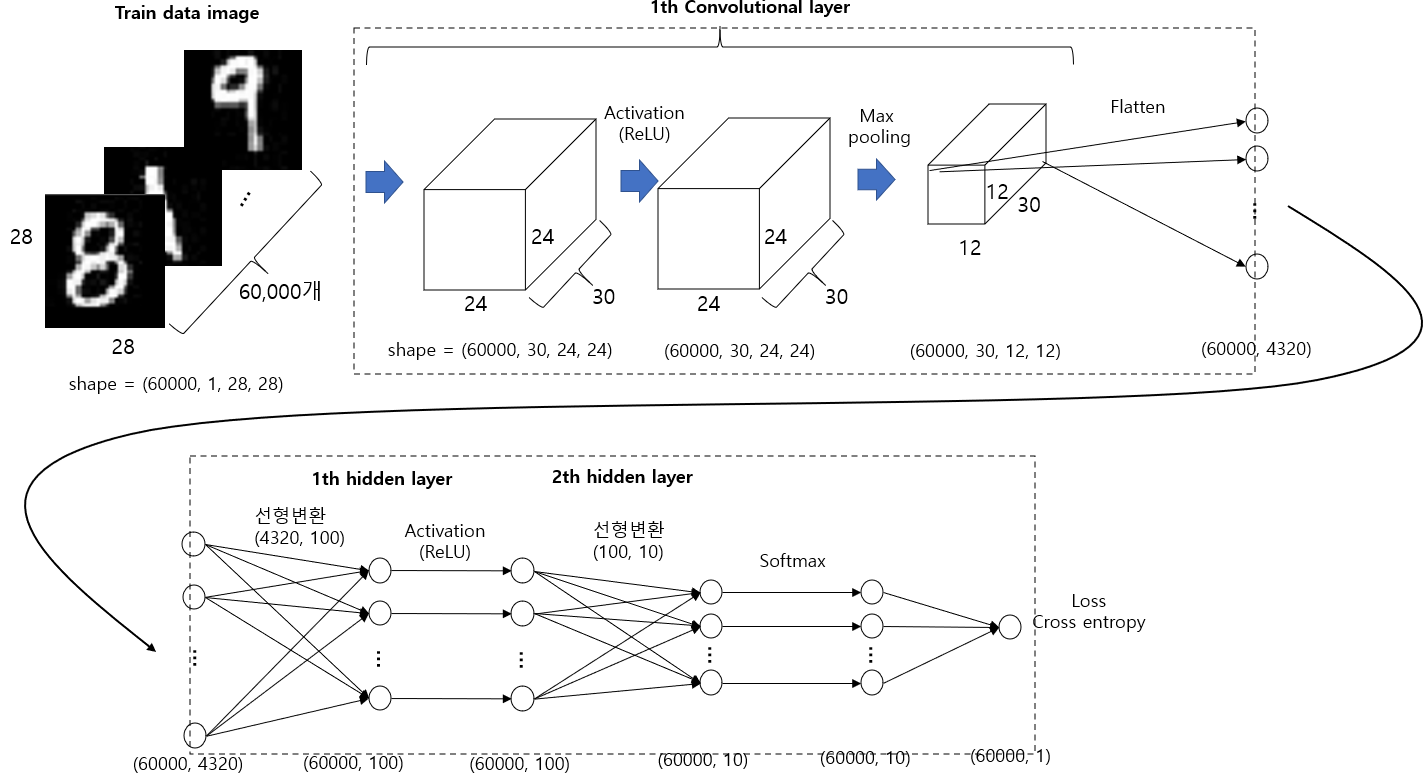

- 설계된 conv net의 class 뜯어보기

In [7]:
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

In [8]:
print("선언된 간단한 합성곱 신경망 파라미터들 shape : ")
print("1번째 합성곱 층의 필터 파라미터 : ", np.shape(network.params['W1']))
print("1번째 합성곱 층의 편향 파라미터 : ", np.shape(network.params['b1']))
print("1번째 FCNN 층의 가중치 파라미터 : ", np.shape(network.params['W2']))
print("1번째 FCNN 층의 편향 파라미터 : ", np.shape(network.params['b2']))
print("2번째 FCNN 층의 가중치 파라미터 : ", np.shape(network.params['W3']))
print("2번째 FCNN 층의 편향 파라미터 : ", np.shape(network.params['b3']))

선언된 간단한 합성곱 신경망 파라미터들 shape : 
1번째 합성곱 층의 필터 파라미터 :  (30, 1, 5, 5)
1번째 합성곱 층의 편향 파라미터 :  (30,)
1번째 FCNN 층의 가중치 파라미터 :  (4320, 100)
1번째 FCNN 층의 편향 파라미터 :  (100,)
2번째 FCNN 층의 가중치 파라미터 :  (100, 10)
2번째 FCNN 층의 편향 파라미터 :  (10,)


#### 임의로 이미지 1개가 모델의 입력으로 들어갔다고 가정했을 때 각 레이어의 shape을 출력

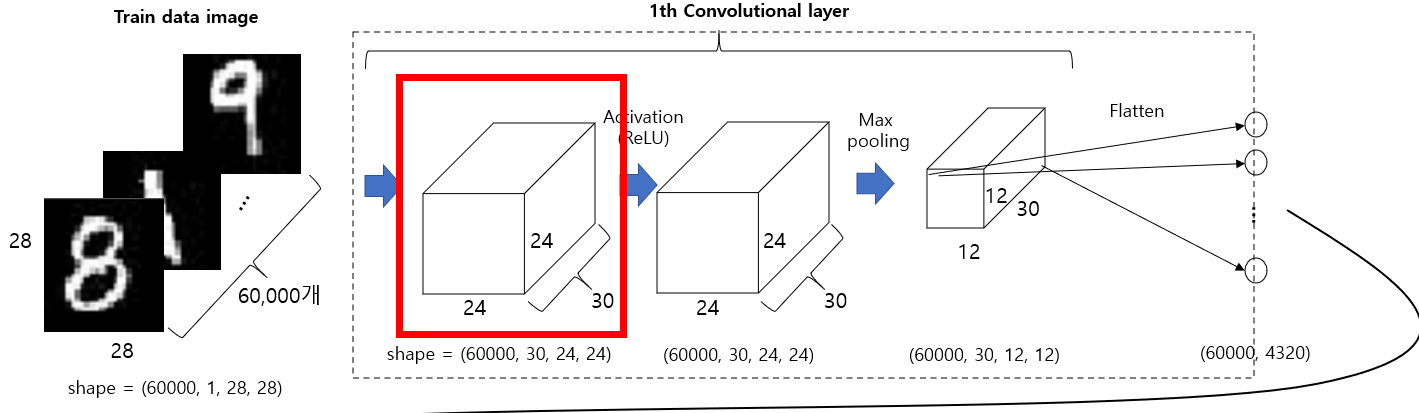

In [9]:
image1 = np.reshape(X_train[0], (1,1,28,28))
output = network.layers['Conv1'].forward(image1)
print(np.shape(output))

(1, 30, 24, 24)


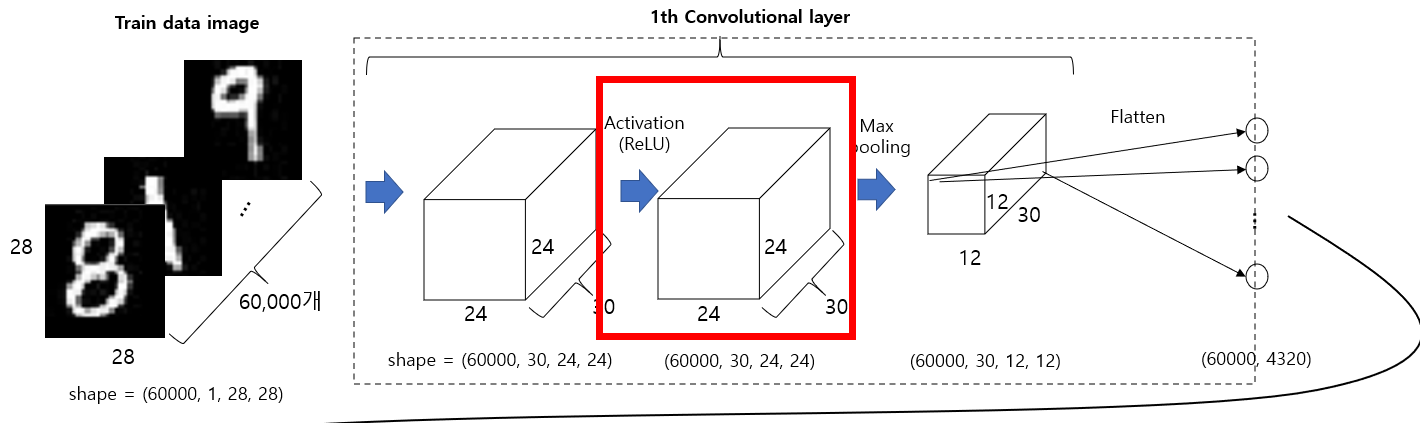

In [10]:
output = network.layers['Relu1'].forward(output)
print(np.shape(output))

(1, 30, 24, 24)


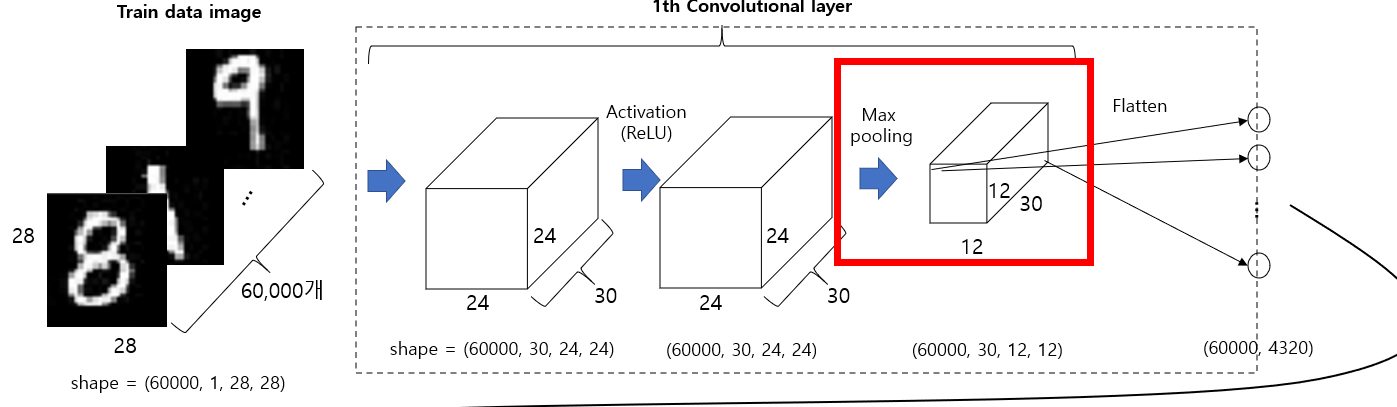

In [11]:
output = network.layers['Pool1'].forward(output)
print(np.shape(output))

(1, 30, 12, 12)


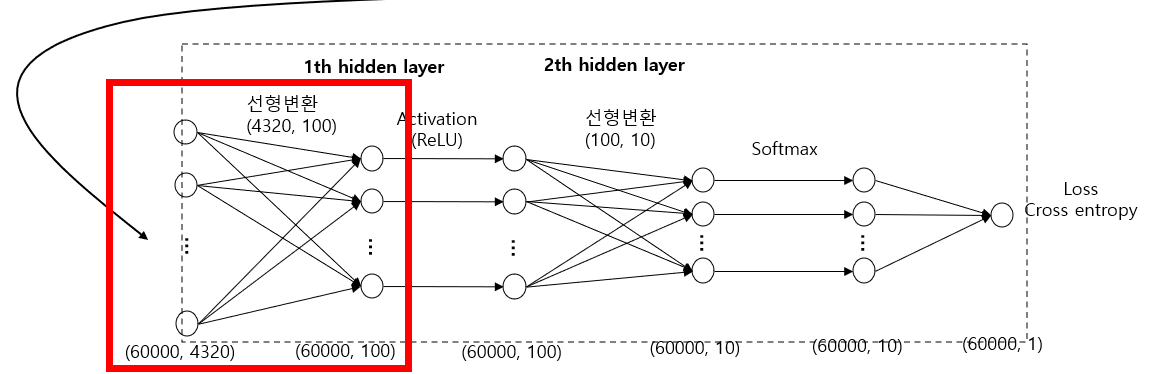

In [12]:
output = network.layers['Affine1'].forward(output)
print(np.shape(output))

(1, 100)


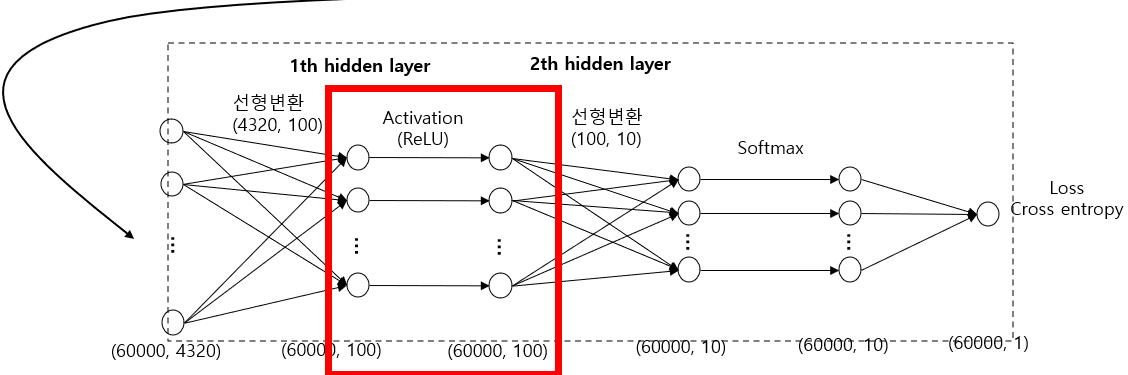

In [13]:
output = network.layers['Relu2'].forward(output)
print(np.shape(output))

(1, 100)


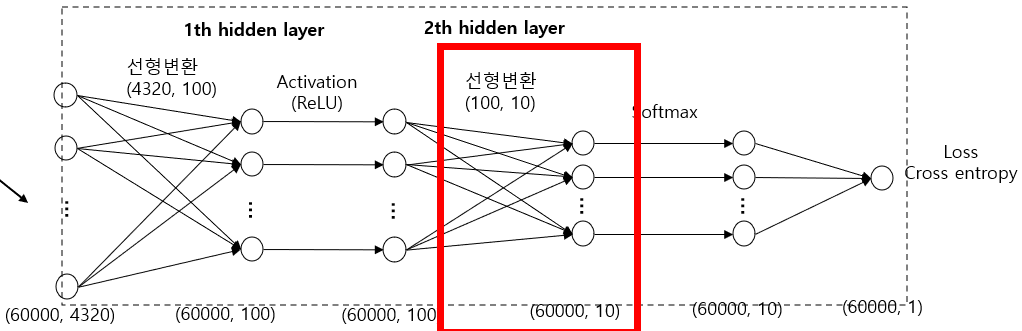

In [14]:
output = network.layers['Affine2'].forward(output)
print(np.shape(output))

(1, 10)


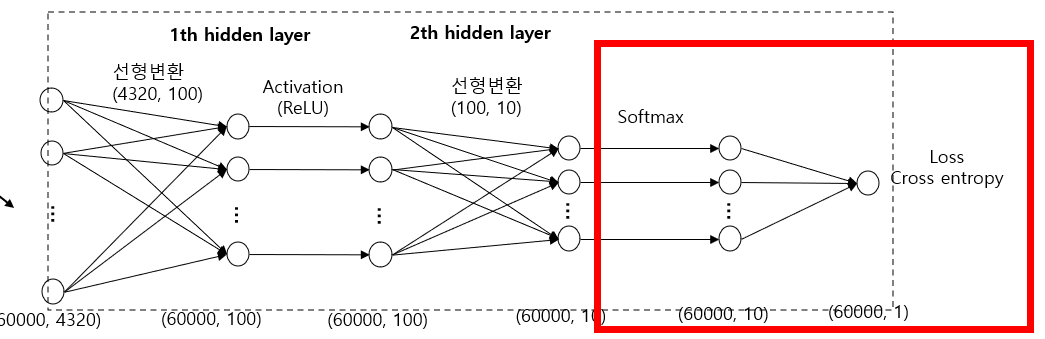

In [15]:
t = np.random.randn(1, 10)
output = network.last_layer.forward(output, t)
print(np.shape(output))
print(output)

()
2.3024530164517745


# 
#### 학습 (주의 : CPU만 사용하므로 계산 시간 오래걸림)

In [18]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [20]:
import time

lr = 0.01
batch_size = 100
epochs = 5
Train_loss_list = []
Test_loss_list = []

start = time.time() # 시작 시간 기록
for i in range(epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
        grads = network.gradient(X_batch, y_batch)
        for key in network.params.keys():
            network.params[key] -= lr * grads[key]

    train_loss = network.loss(X_train[:1000], y_train[:1000])
    test_loss = network.loss(X_test[:1000], y_test[:1000])
    Train_loss_list.append(train_loss)
    Test_loss_list.append(test_loss)

    print("Train data 60,000 : {}th 에폭 손실값 : {}".format(i, train_loss))
    print("Test data 10,000 : {}th 에폭 손실값 : {}".format(i, test_loss))

    train_acc = network.accuracy(X_train[:1000], y_train[:1000])
    test_acc = network.accuracy(X_test[:1000], y_test[:1000])
    print("Train data 60,000 : {}th 에폭 정확도 : {}".format(i, train_acc))
    print("Test data 10,000 : {}th 에폭 정확도 : {}".format(i, test_acc))

end = time.time() # 종료 시간 기록
elapsed_time_seconds = end - start # 총 걸린 시간을 초 단위로 계산
elapsed_time_minutes = elapsed_time_seconds / 60 # 초를 분으로 변환

print("총 학습에 걸린 시간 (분) :", elapsed_time_minutes)

Train data 60,000 : 0th 에폭 손실값 : 2.298837247979638
Test data 10,000 : 0th 에폭 손실값 : 2.298296455781112
Train data 60,000 : 0th 에폭 정확도 : 0.116
Test data 10,000 : 0th 에폭 정확도 : 0.126
Train data 60,000 : 1th 에폭 손실값 : 2.180592969775316
Test data 10,000 : 1th 에폭 손실값 : 2.184048203423166
Train data 60,000 : 1th 에폭 정확도 : 0.283
Test data 10,000 : 1th 에폭 정확도 : 0.335
Train data 60,000 : 2th 에폭 손실값 : 0.535871428752788
Test data 10,000 : 2th 에폭 손실값 : 0.518501901535194
Train data 60,000 : 2th 에폭 정확도 : 0.835
Test data 10,000 : 2th 에폭 정확도 : 0.848
Train data 60,000 : 3th 에폭 손실값 : 0.4031639006683348
Test data 10,000 : 3th 에폭 손실값 : 0.37957854201958424
Train data 60,000 : 3th 에폭 정확도 : 0.878
Test data 10,000 : 3th 에폭 정확도 : 0.878
Train data 60,000 : 4th 에폭 손실값 : 0.3581687612664034
Test data 10,000 : 4th 에폭 손실값 : 0.3199955585391931
Train data 60,000 : 4th 에폭 정확도 : 0.892
Test data 10,000 : 4th 에폭 정확도 : 0.893
총 학습에 걸린 시간 (분) : 4.418646279970805


In [22]:
test_acc = network.accuracy(X_test, y_test)
print("학습이 끝난 후 최종 Test data 정확도 : ",test_acc)

학습이 끝난 후 최종 Test data 정확도 :  0.9082


# 
# 
## 2. 합성곱 신경망에서 합성곱은 [ Convolution 연산, Activation 연산, Pooling 연산 ] 3가지로 이루어짐

### 2-1. Convolution 연산의 전파와 역전파를 Class로 구현
#### 핵심 Concept : 
- Convolution의 연산을 자세히 들여다보면 이미지와 filter의 내적임을 알 수 있음
- 그렇다면 Convolution 연산은 이미지를 행렬로, 필터를 벡터 혹은 행렬로 표현하여 행렬변환으로 연산할 수 있음을 의미함.
- 이에 Backpropagation을 구현하는 미분 단계에서도 행렬에 미분을 그대로 적용할 수 있음

- 먼저 Convolution 연산을 뜯어보자

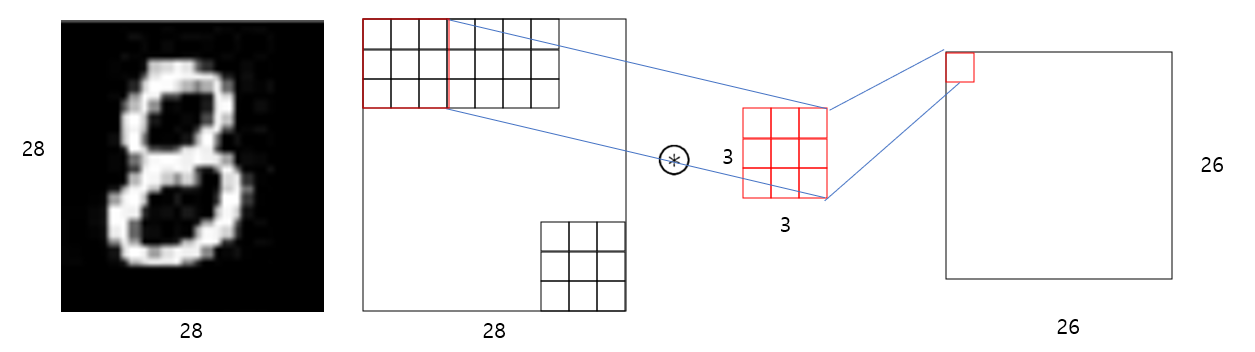

In [23]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        print("필터의 형태 : (필터 수, 채널 수, 가로, 세로)", FN, C, FH, FW)
        N, C, H, W = x.shape
        print("입력 데이터 형태 : (데이터 수, 채널 수, 가로, 세로)", N, C, H, W)
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        print("패딩과 stride를 하고 나면 나오는 shape : ", out_h, out_w)

        col = im2col(x, FH, FW, self.stride, self.pad)
        print("데이터를 필터 형태에 맞게 행렬로 변환한 shape :", np.shape(col))
        col_W = self.W.reshape(FN, -1).T
        print("필터를 벡터로 변환한 shape : ", np.shape(col_W))

        out = np.dot(col, col_W) + self.b
        print("행렬변환으로 계산한 출력 모양 : ", np.shape(out))
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        print("다시 이미지로 변환한 모양 : ", np.shape(out))

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        print("뒤쪽에서 전달받은 오차역전파 미분 형태 : ", np.shape(dout))
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        print("합성곱에서 미분을 구하는 과정보다 행렬변환의 미분 계산이 코드 구현에 용이하므로 전달받은 역전파 미분을 행렬로 변환")
        print("0은 데이터 수, 2와3은 가로와 세로, 1은 채널 수를 뜻함")
        print("채널 수를 뒤쪽으로 빼고 데이터 수 X 가로 X 세로 로 행렬로 표현 : ", np.shape(dout))

        self.db = np.sum(dout, axis=0)
        print("필터에 대한 현단계에서 합성곱의 미분은 행렬로 표현되었으므로 Affine의 backward의 미분과 동일함")
        self.dW = np.dot(self.col.T, dout)
        print("필터 가중치 미분 모양 (행렬변환에 대한 미분으로 곱 후): ", np.shape(self.dW))
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        print("필터 가중치 미분 모양 (필터 형태로 변환 후): ", np.shape(self.dW))

        print("dcol 은 다음 역전파로 넘기기 위한 미분")
        dcol = np.dot(dout, self.col_W.T)
        print("행렬변환 미분으로 계산한 dcol 형태 : ", np.shape(dcol))
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        print("다음 역전파로 보내기 위해 reshape : ", np.shape(dx))

        return dx

- Convolution forward 출력 결과 :

In [24]:
X = np.reshape(X_train[0], (1,1,28,28))
W = np.random.randn(1, 1, 3, 3)
b = np.zeros(1,)

conv = Convolution(W, b)
out = conv.forward(X)
print(np.shape(out))

필터의 형태 : (필터 수, 채널 수, 가로, 세로) 1 1 3 3
입력 데이터 형태 : (데이터 수, 채널 수, 가로, 세로) 1 1 28 28
패딩과 stride를 하고 나면 나오는 shape :  26 26
데이터를 필터 형태에 맞게 행렬로 변환한 shape : (676, 9)
필터를 벡터로 변환한 shape :  (9, 1)
행렬변환으로 계산한 출력 모양 :  (676, 1)
다시 이미지로 변환한 모양 :  (1, 1, 26, 26)
(1, 1, 26, 26)


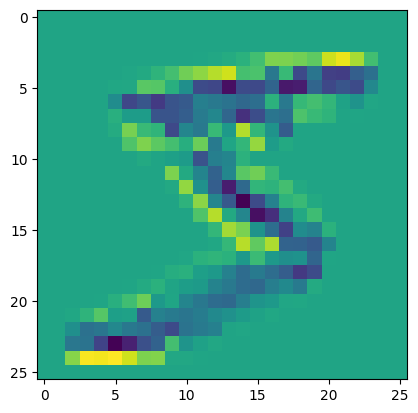

In [27]:
plt.imshow(out[0,0])
plt.show()

- Convolution backward 출력 결과 :

In [28]:
dout = np.ones((1,1,26,26))

dout = conv.backward(dout)
print(np.shape(dout))

뒤쪽에서 전달받은 오차역전파 미분 형태 :  (1, 1, 26, 26)
합성곱에서 미분을 구하는 과정보다 행렬변환의 미분 계산이 코드 구현에 용이하므로 전달받은 역전파 미분을 행렬로 변환
0은 데이터 수, 2와3은 가로와 세로, 1은 채널 수를 뜻함
채널 수를 뒤쪽으로 빼고 데이터 수 X 가로 X 세로 로 행렬로 표현 :  (676, 1)
필터에 대한 현단계에서 합성곱의 미분은 행렬로 표현되었으므로 Affine의 backward의 미분과 동일함
필터 가중치 미분 모양 (행렬변환에 대한 미분으로 곱 후):  (9, 1)
필터 가중치 미분 모양 (필터 형태로 변환 후):  (1, 1, 3, 3)
dcol 은 다음 역전파로 넘기기 위한 미분
행렬변환 미분으로 계산한 dcol 형태 :  (676, 9)
다음 역전파로 보내기 위해 reshape :  (1, 1, 28, 28)
(1, 1, 28, 28)


## 
#### 합성곱 층에서 합성곱에 대한 연산을 선형변환으로 변환하여 연산하기 위한 모듈
1. im2col : 이미지를 합성곱 옵션(filter 크기, stride, pad 등)에 따라 선형변환하기 위한 행렬로 변환하는 모듈
2. col2im : 선형변환한 행렬을 다시 이미지로 만들기 위한 모듈

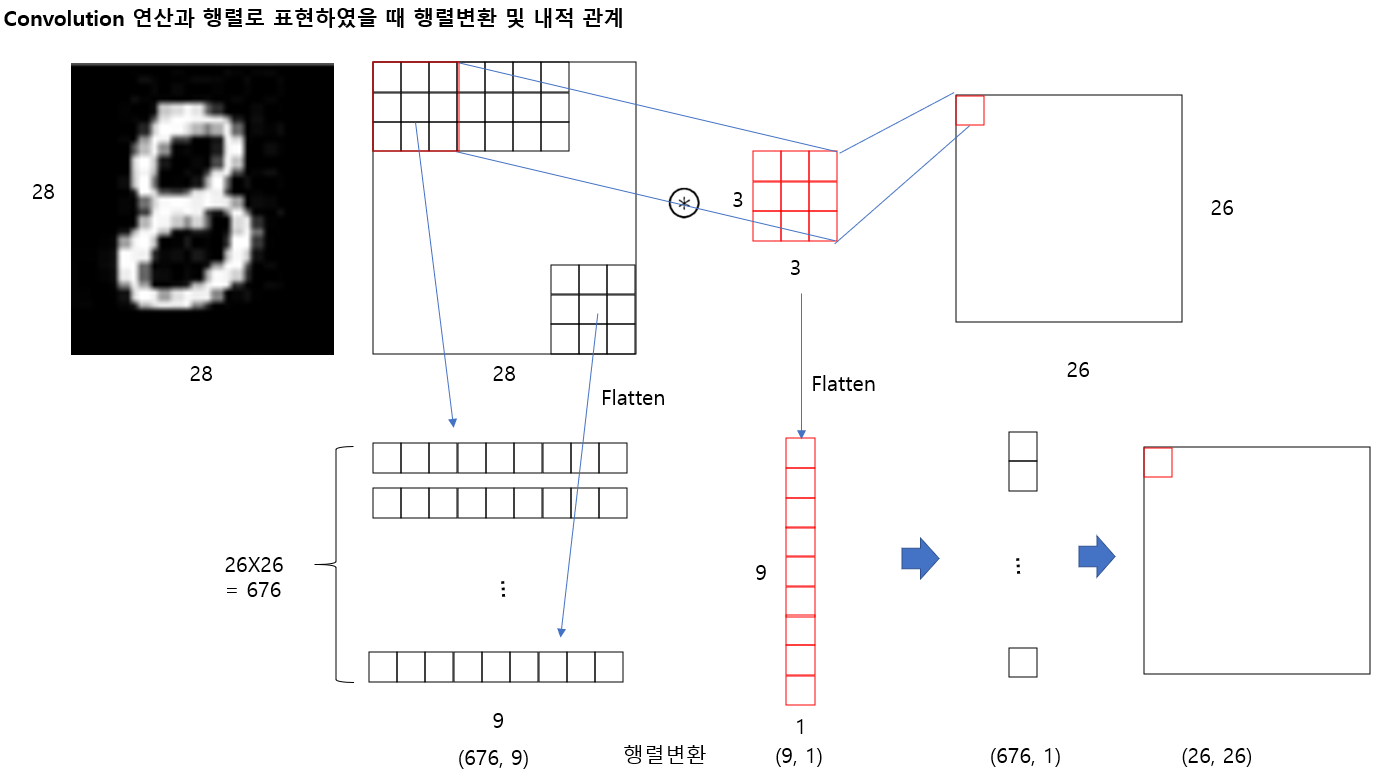

In [30]:
col = im2col(X, 3,3, stride=1, pad=0)
print(np.shape(col))

(676, 9)


In [33]:
col_W = np.reshape(W, (3*3, -1))
print(np.shape(col_W))

(9, 1)


In [34]:
out = np.dot(col, col_W)
print(np.shape(out))

(676, 1)


In [35]:
out = np.reshape(out, (1,1, 26, 26))
print(np.shape(out))

(1, 1, 26, 26)


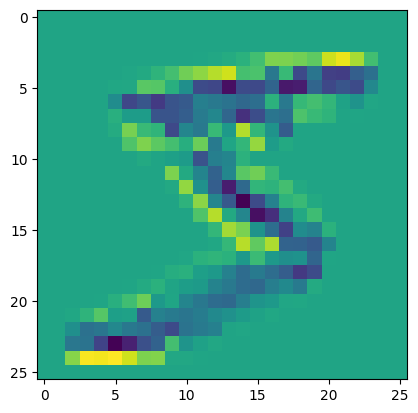

In [36]:
plt.imshow(out[0,0])
plt.show()

- 역전파에 사용되는 col2im

In [37]:
dout = np.ones((1,1, 26, 26))
print(np.shape(dout))

(1, 1, 26, 26)


In [38]:
FN, C, FH, FW = W.shape
dout = dout.transpose(0,2,3,1).reshape(-1, FN)
print(np.shape(dout))

(676, 1)


In [39]:
dW = np.dot(col.T, dout)
print(np.shape(dW))

(9, 1)


In [41]:
dcol = np.dot(dout, col_W.T)
print(np.shape(dcol))

(676, 9)


In [42]:
dx = col2im(dcol, X.shape, 3, 3, stride=1, pad=0)
print(np.shape(dx))

(1, 1, 28, 28)


## 
### 2. Activation인 비선형변환은 Class에서 원소곱으로 진행되므로 기존 DNN 모듈과 동일함

## 
### 3. Pooling 연산의 전파와 역전파를 Class로 구현
#### 핵심 Concept : 
- Pooling 연산 또한 행렬로 변환하여 계산하는 것이 용이함.

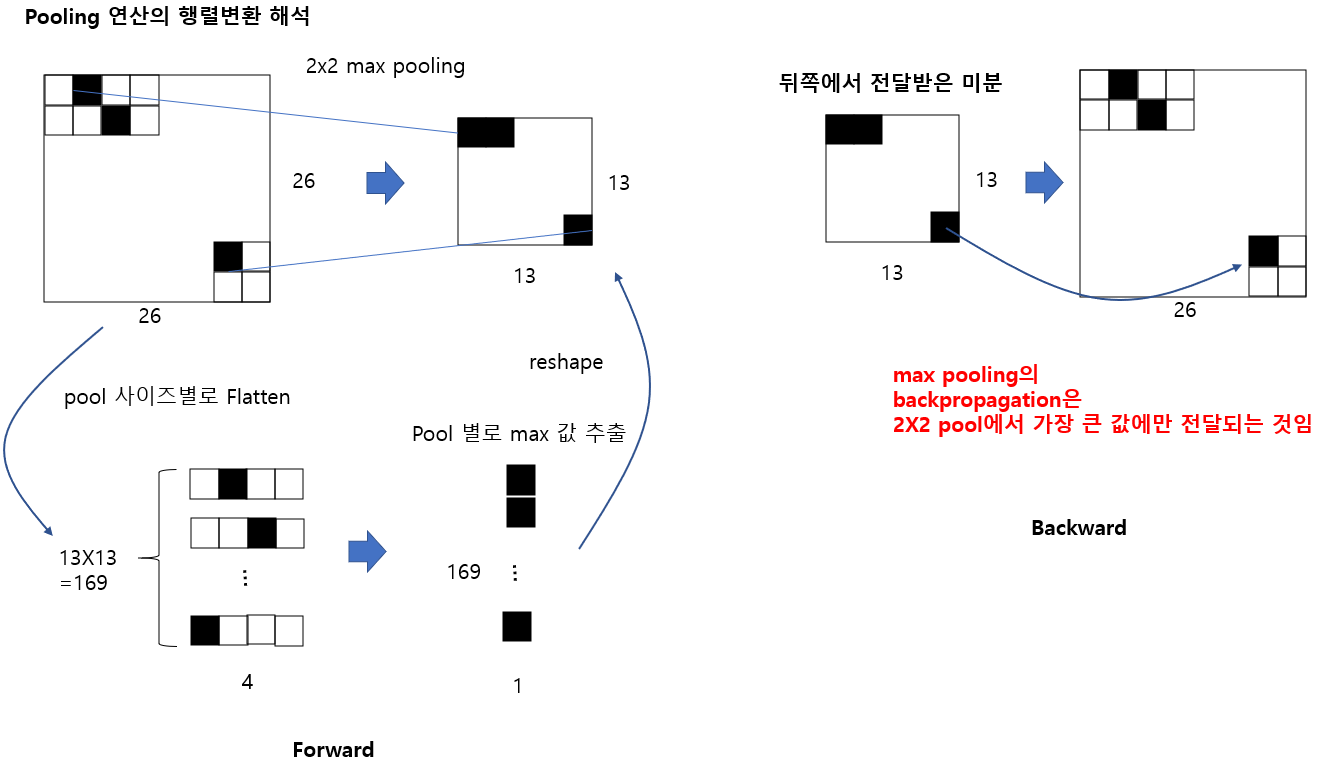

In [43]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        print("입력 데이터 형태 : (데이터 수, 채널 수, 높이, 너비)", N, C, H, W)
        
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        print("출력 데이터 크기 계산 (패딩과 stride 적용 후 높이와 너비) : ", out_h, out_w)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        print("입력 데이터를 im2col로 변환하여 행렬로 변환된 형태 :", np.shape(col))

        col = col.reshape(-1, self.pool_h * self.pool_w)
        print("각 윈도우별 데이터가 한 행으로 정렬된 형태 : ", np.shape(col))

        arg_max = np.argmax(col, axis=1)
        print("최대값 인덱스(arg_max)를 찾음 : ", np.shape(arg_max))
        
        out = np.max(col, axis=1)
        print("최대값 계산 결과 (평탄화된 출력): ", np.shape(out))

        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        print("최종 Pooling 후 출력 데이터 형태 : ", np.shape(out))

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        print("뒤쪽에서 전달받은 오차역전파 미분 형태 : ", np.shape(dout))
        dout = dout.transpose(0, 2, 3, 1)
        print("채널을 뒤로 보낸 미분 데이터 형태 : ", np.shape(dout))

        pool_size = self.pool_h * self.pool_w
        print("Pool 크기 (pool_h * pool_w): ", pool_size)

        dmax = np.zeros((dout.size, pool_size))
        print("dmax (초기화된 Zero 배열): ", np.shape(dmax))

        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        print("arg_max 인덱스를 기준으로 역전파 기울기를 대입한 dmax: ", np.shape(dmax))
        print(dmax)
        
        dmax = dmax.reshape(dout.shape + (pool_size,))
        print("dmax를 다시 다차원 형태로 변환 : ", np.shape(dmax))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        print("im2col 형태로 변환된 dcol : ", np.shape(dcol))

        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        print("원래 입력 데이터 크기로 복원된 dx : ", np.shape(dx))

        return dx


In [44]:
# Pooling 연산
pool = Pooling(pool_h=2, pool_w=2, stride=2, pad=0)
print("== Pooling Forward ==")
pool_out = pool.forward(out)
print("Pooling 결과 Shape:", np.shape(pool_out))


== Pooling Forward ==
입력 데이터 형태 : (데이터 수, 채널 수, 높이, 너비) 1 1 26 26
출력 데이터 크기 계산 (패딩과 stride 적용 후 높이와 너비) :  13 13
입력 데이터를 im2col로 변환하여 행렬로 변환된 형태 : (169, 4)
각 윈도우별 데이터가 한 행으로 정렬된 형태 :  (169, 4)
최대값 인덱스(arg_max)를 찾음 :  (169,)
최대값 계산 결과 (평탄화된 출력):  (169,)
최종 Pooling 후 출력 데이터 형태 :  (1, 1, 13, 13)
Pooling 결과 Shape: (1, 1, 13, 13)


In [45]:
print("== Pooling Backward ==")
dout = pool_out
pool_dout = pool.backward(dout)
print("Pooling 미분 결과 Shape:", np.shape(pool_out))


== Pooling Backward ==
뒤쪽에서 전달받은 오차역전파 미분 형태 :  (1, 1, 13, 13)
채널을 뒤로 보낸 미분 데이터 형태 :  (1, 13, 13, 1)
Pool 크기 (pool_h * pool_w):  4
dmax (초기화된 Zero 배열):  (169, 4)
arg_max 인덱스를 기준으로 역전파 기울기를 대입한 dmax:  (169, 4)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0